In [18]:
from analyse_helper import load_ocelot_data
import numpy as np
import matplotlib.pyplot as plt
import json
import glob
import torch
from botorch.fit import fit_gpytorch_model
from botorch.models import SingleTaskGP
from botorch.models.transforms import Normalize, Standardize
from gpytorch.mlls import ExactMarginalLogLikelihood

BASE_DIR = "../2022-11-24-data/"

## Look into the 4d optimization data

In [4]:
with open(BASE_DIR+"/bo/benchmark_ucb_2022_11_24-09_11_00.json", "r") as f:
    data = json.load(f)

In [24]:
X = np.array(data["X"])
Y = np.array(data["Y"])
print(X.shape, Y.shape)
print("Min", np.min(X,axis=0))
print("Max", np.max(X,axis=0))
print(X[np.argmax(Y)])
print("Mean", np.mean(X, axis=0))

(56, 4) (56,)
Min [ 2.13730189e-05 -1.43588687e-02 -6.78212494e-02 -2.55248964e-01]
Max [0.11032136 0.06095994 0.16175783 0.09440861]
[0.00237895 0.05838207 0.15619454 0.01294369]
Mean [0.02025177 0.04396096 0.11443921 0.00303102]


In [19]:
gp = SingleTaskGP(
                train_X=torch.tensor(X),
                train_Y=torch.tensor(Y).reshape(-1,1),
                outcome_transform=Standardize(1),
                input_transform=Normalize(X.shape[1]),
            )
mll = ExactMarginalLogLikelihood(gp.likelihood, gp)
fit_gpytorch_model(mll)

ExactMarginalLogLikelihood(
  (likelihood): GaussianLikelihood(
    (noise_covar): HomoskedasticNoise(
      (noise_prior): GammaPrior()
      (raw_noise_constraint): GreaterThan(1.000E-04)
    )
  )
  (model): SingleTaskGP(
    (likelihood): GaussianLikelihood(
      (noise_covar): HomoskedasticNoise(
        (noise_prior): GammaPrior()
        (raw_noise_constraint): GreaterThan(1.000E-04)
      )
    )
    (mean_module): ConstantMean()
    (covar_module): ScaleKernel(
      (base_kernel): MaternKernel(
        (lengthscale_prior): GammaPrior()
        (raw_lengthscale_constraint): Positive()
        (distance_module): Distance()
      )
      (outputscale_prior): GammaPrior()
      (raw_outputscale_constraint): Positive()
    )
    (outcome_transform): Standardize()
    (input_transform): Normalize()
  )
)

In [116]:
gp.mean_module.constant

Parameter containing:
tensor(-1.3478, dtype=torch.float64, requires_grad=True)

In [94]:
xmin, xmax = -0.25, 0.25
n_points = 50
ndim = 4
mean_values = np.mean(X, axis=0)
xlist = np.linspace(xmin, xmax, n_points)
ylist = np.linspace(xmin, xmax, n_points)
XX, YY = np.meshgrid(xlist,ylist)

inputs = torch.zeros(n_points**2, ndim)
inputs[:] = torch.tensor(mean_values)
zvalues = np.zeros((4,4,n_points,n_points))
for i in range(4):
    for j in range(4):
        input_copy = torch.clone(inputs.detach())
        input_copy[:,i] = torch.tensor(XX.flatten())
        input_copy[:,j] = torch.tensor(YY.flatten())
        prediction = gp.posterior(input_copy)
        ZZ = prediction.mean.detach().numpy().reshape(n_points,n_points)
        zvalues[i,j] = ZZ
# inputs[:,1] = torch.tensor(XX.flatten())
# inputs[:,3] = torch.tensor(YY.flatten())
# inputs[:,0] = mean_values[0]
# inputs[:,1] = mean_values[1]
# inputs[:,2] = mean_values[2]
# inputs[:,3] = mean_values[3]

# prediction = gp.posterior(inputs)
# ZZ = prediction.mean.detach().numpy().reshape(n_points,n_points)

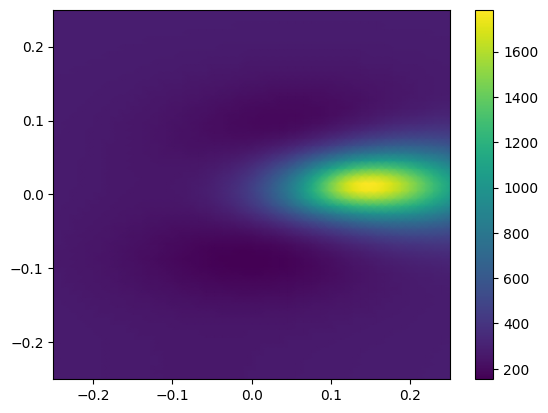

In [117]:
# plt.imshow(ZZ)
i, j = 0, 1
plt.pcolormesh(XX,YY, zvalues[2,3], shading="gouraud")
plt.colorbar()

(array([[ 1.,  1.,  0.,  0.,  8., 30.],
        [ 0.,  0.,  0.,  5.,  0.,  0.],
        [ 1.,  1.,  0.,  3.,  0.,  0.],
        [ 0.,  0.,  2.,  0.,  1.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  3.,  0.]]),
 array([2.13730189e-05, 1.84047038e-02, 3.67880346e-02, 5.51713654e-02,
        7.35546962e-02, 9.19380270e-02, 1.10321358e-01]),
 array([-0.01435887, -0.00180573,  0.0107474 ,  0.02330054,  0.03585367,
         0.0484068 ,  0.06095994]),
 <matplotlib.collections.QuadMesh at 0x7ff740905f40>)

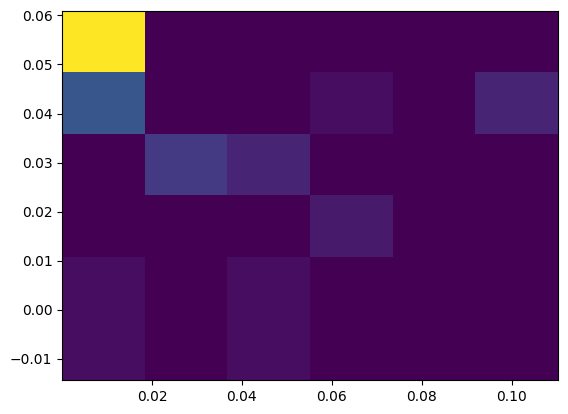

In [10]:
plt.hist2d(X[:,0],X[:,1],bins=(6,6))